In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline
plt.rcParams["font.family"] = "Hiragino Maru Gothic Pro"
import warnings
warnings.filterwarnings("ignore")

In [3]:
import requests
import io

url = 'https://covid19.mhlw.go.jp/public/opendata/newly_confirmed_cases_daily.csv'
res = requests.get(url).content
df = pd.read_csv(io.StringIO(res.decode('utf-8')), header=0, index_col=0, parse_dates=True)

target = "Tokyo"
df["log_Tokyo"] = np.log1p(df[target]).diff()
# 前日
df["a_day_ago_Tokyo"] = df["log_Tokyo"].shift(1)

In [4]:
df.head()

,ALL,Hokkaido,Aomori,Iwate,Miyagi,Akita,Yamagata,Fukushima,Ibaraki,Tochigi,...,Fukuoka,Saga,Nagasaki,Kumamoto,Oita,Miyazaki,Kagoshima,Okinawa,log_Tokyo,a_day_ago_Tokyo
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-16,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,NaN,NaN
2020-01-17,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.0,NaN
2020-01-18,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.0,0.0
2020-01-19,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.0,0.0
2020-01-20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.0,0.0


In [5]:
df.tail()

,ALL,Hokkaido,Aomori,Iwate,Miyagi,Akita,Yamagata,Fukushima,Ibaraki,Tochigi,...,Fukuoka,Saga,Nagasaki,Kumamoto,Oita,Miyazaki,Kagoshima,Okinawa,log_Tokyo,a_day_ago_Tokyo
Date,,,,,,,,,,,,,,,,,,,,,
2022-05-04,26421,2090,246,221,326,173,137,319,498,207,...,1557,175,361,314,247,372,469,1201,-0.112733,0.334212
2022-05-05,20713,1854,290,197,210,170,125,339,481,233,...,1372,244,229,255,230,225,420,1327,-0.256614,-0.112733
2022-05-06,21547,1668,153,181,230,181,115,324,340,262,...,1181,294,203,290,258,287,521,1398,0.144565,-0.256614
2022-05-07,39239,2112,356,270,538,329,201,499,348,638,...,2209,495,578,736,466,464,928,2375,0.351066,0.144565
2022-05-08,42415,3115,362,362,570,269,258,599,429,492,...,2375,230,585,536,414,624,733,2060,0.212483,0.351066


In [10]:
# 目的変数
target_column = "log_Tokyo"
# 説明変数 
ex_columns = [
    "a_day_ago_Tokyo",
]

# 学習期間の設定
train_start = df.index.get_loc("2022-01-01")
train_end = df.index.get_loc("2022-04-01")
test_start = df.index.get_loc("2022-04-01")
test_end = len(df) -1 # 最後まで

w = 7 # 窓幅
N = 1 # N期先予測

# 学習データ
df_tr = df.iloc[train_start : train_end]
Ytr = df_tr[target_column].to_numpy().ravel()
Xtr = df_tr[target_column].to_numpy()
Ytr_org = df.iloc[train_start-1 : train_end]["Tokyo"]
Ytr_org = Ytr_org[N+w-1 : -1]
print("Training data", len(Xtr))


# テストデータ
df_ts = df.iloc[test_start : test_end]
Yts = df_ts[target_column].to_numpy().ravel()
Xts = df_ts[target_column].to_numpy()
Yts_org = df.iloc[test_start-1 : test_end]["Tokyo"]
Yts_org = Yts_org[N+w-1 : -1]
print("Test data", len(Xts))

Training data 90
Test data 37


In [11]:
Ytr.shape, Yts.shape

((90,), (37,))

In [12]:
from sklearn.preprocessing import StandardScaler

# 標準化
scalerX = StandardScaler()
scalerY = StandardScaler()
Xtr_norm = scalerX.fit_transform(Xtr.reshape(-1, 1))
Ytr_norm = scalerY.fit_transform(Ytr.reshape(-1, 1))
Xts_norm = scalerX.transform(Xts.reshape(-1, 1))
Yts_norm = scalerY.transform(Yts.reshape(-1, 1))

In [13]:
Xtr_norm.shape

(90, 1)

In [14]:
# 学習データ
Xtr_trs = Xtr_norm
for i in range(w-1):
    Xtr_trs = np.hstack([Xtr_trs, np.roll(Xtr_norm, i+1)])
Xtr_trs = Xtr_trs[N+w-1:] # 学習データの説明変数の前からN+w-1行は削れる
Ytr_trs = np.roll(Ytr_norm, -N) # 予測先のNだけずらす
Ytr_trs = Ytr_trs[N+w-1:]
print(Xtr_trs.shape, Ytr_trs.shape)


# テストデータ
Xts_trs = Xts_norm
for i in range(w):
    Xts_trs = np.hstack([Xts_trs, np.roll(Xts_norm, i+1)])
Xts_trs = Xts_trs[N+w-1:]
Yts_trs = np.roll(Yts_norm, -N)
Yts_trs = Yts_trs[N+w-1:]
print(Xts_trs.shape, Yts_trs.shape)

(83, 8) (83, 1)
(30, 8) (30, 1)


In [19]:
Xtr_trs

array([[ 0.59222125,  0.67156812,  0.98869121,  2.19693382,  0.21409126,
         1.40542285, -0.72887515,  0.12647349],
       [-0.27453903,  0.59222125,  0.67156812,  0.98869121,  2.19693382,
         0.21409126,  1.40542285, -0.72887515],
       [-0.73886748, -0.27453903,  0.59222125,  0.67156812,  0.98869121,
         2.19693382,  0.21409126,  1.40542285],
       [-0.25151341, -0.73886748, -0.27453903,  0.59222125,  0.67156812,
         0.98869121,  2.19693382,  0.21409126],
       [ 2.03032913, -0.25151341, -0.73886748, -0.27453903,  0.59222125,
         0.67156812,  0.98869121,  2.19693382],
       [ 0.90060477,  2.03032913, -0.25151341, -0.73886748, -0.27453903,
         0.59222125,  0.67156812,  0.98869121],
       [ 0.16029437,  0.90060477,  2.03032913, -0.25151341, -0.73886748,
        -0.27453903,  0.59222125,  0.67156812],
       [ 0.3046417 ,  0.16029437,  0.90060477,  2.03032913, -0.25151341,
        -0.73886748, -0.27453903,  0.59222125],
       [-0.15474641,  0.3046417 

In [20]:
Ytr_trs

array([[-0.27453903],
       [-0.73886748],
       [-0.25151341],
       [ 2.03032913],
       [ 0.90060477],
       [ 0.16029437],
       [ 0.3046417 ],
       [-0.15474641],
       [-1.23265441],
       [ 1.64859867],
       [ 0.4799426 ],
       [ 0.2016051 ],
       [-0.07545584],
       [ 0.24894975],
       [-0.45999529],
       [-1.13897878],
       [ 1.79496559],
       [-0.16069354],
       [ 0.01311211],
       [ 0.00437807],
       [ 0.04744241],
       [-0.48222689],
       [-1.31705449],
       [ 1.45126562],
       [-0.14756575],
       [-0.0672104 ],
       [-0.01650398],
       [-0.10490613],
       [-0.65151117],
       [-1.32502509],
       [ 1.64187452],
       [-0.34719161],
       [-0.06939007],
       [-0.40437219],
       [-1.69270787],
       [ 1.19391255],
       [-1.63613294],
       [ 1.88863685],
       [-0.30096997],
       [-0.11395736],
       [-0.52662443],
       [-0.10790275],
       [-0.61344963],
       [-1.55225457],
       [ 1.87772662],
       [-0

In [15]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error

a = 100

model = Ridge(alpha=a)
model.fit(Xtr_trs, Ytr_trs)
Ytr_pred = model.predict(Xtr_trs)
# 標準化戻す
Ytr_pred_inv = scalerY.inverse_transform(Ytr_pred).reshape(-1, ) # 予測
Ytr_pred_inv_log_inv = np.expm1(Ytr_pred_inv + np.log1p(Ytr_org)) # expm1(予測値+log1p(前日の値))が予測値になる
print(f'学習MAE：{mean_absolute_error(Ytr_pred_inv_log_inv, Ytr_org)}')

Yts_pred = model.predict(Xts_trs)
# 標準化戻す
Yts_pred_inv = scalerY.inverse_transform(Yts_pred).reshape(-1, ) # 予測
Yts_pred_inv_log_inv = np.expm1(Yts_pred_inv + np.log1p(Yts_org)) # expm1(予測値+log1p(前日の値))が予測値になる
print(f'テストMAE：{mean_absolute_error(Yts_pred_inv_log_inv, Yts_org)}')

学習MAE：1155.5800442947689
テストMAE：599.5936649774643


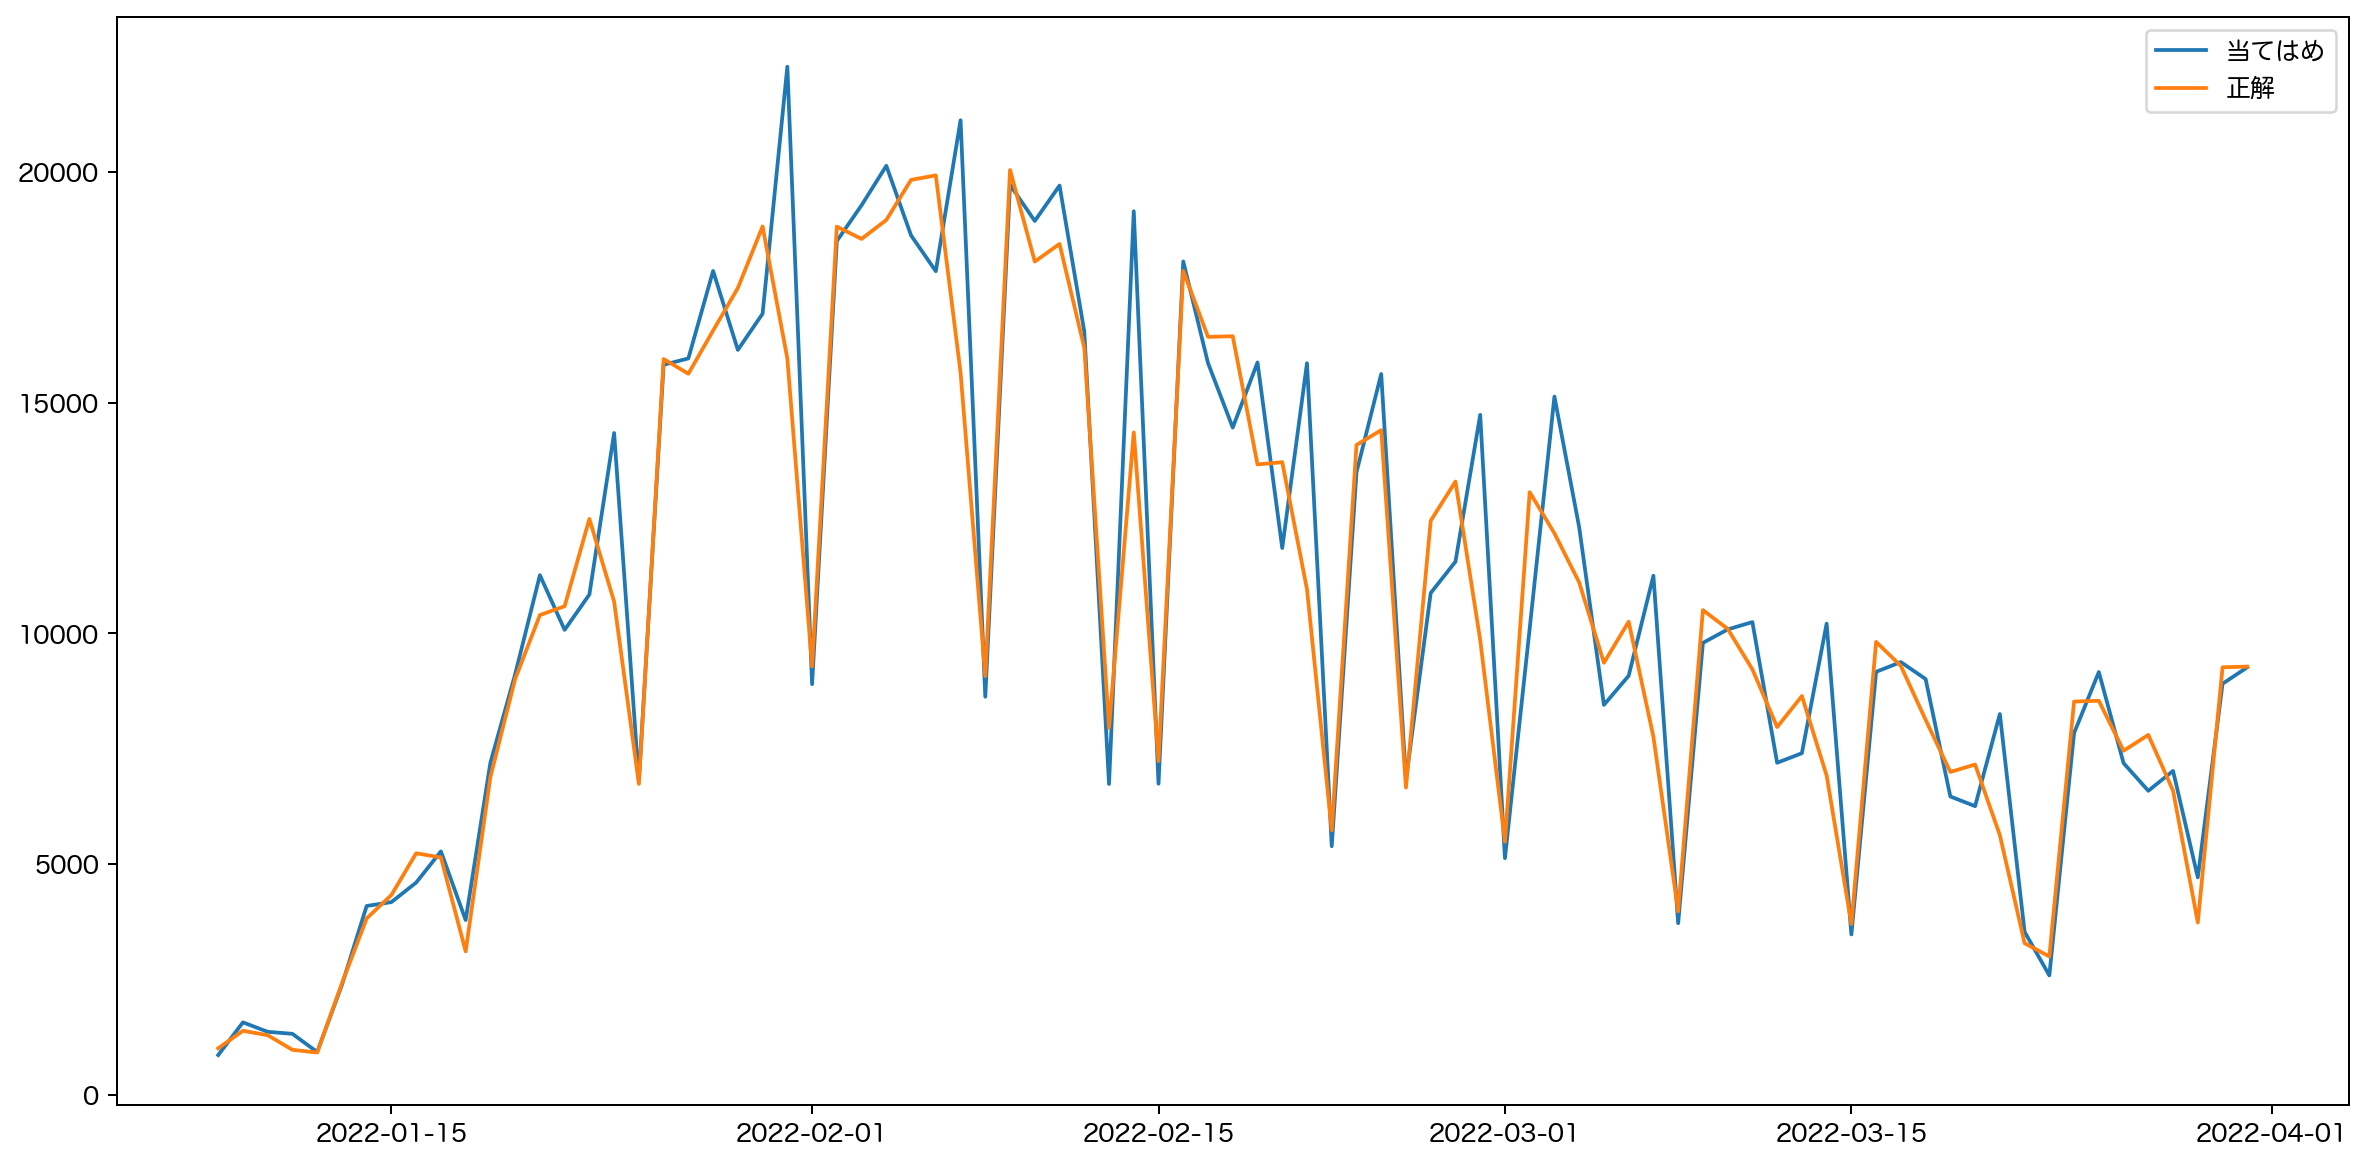

In [16]:
# 学習
fig = plt.figure(figsize=(16, 8), dpi=180)
ax = fig.add_subplot(111)
x = df.index[train_start+(N+w-1):train_end]
ax.plot(x, Ytr_pred_inv_log_inv, label="当てはめ")
ax.plot(x, Ytr_org, label="正解")
ax.legend()
plt.show()

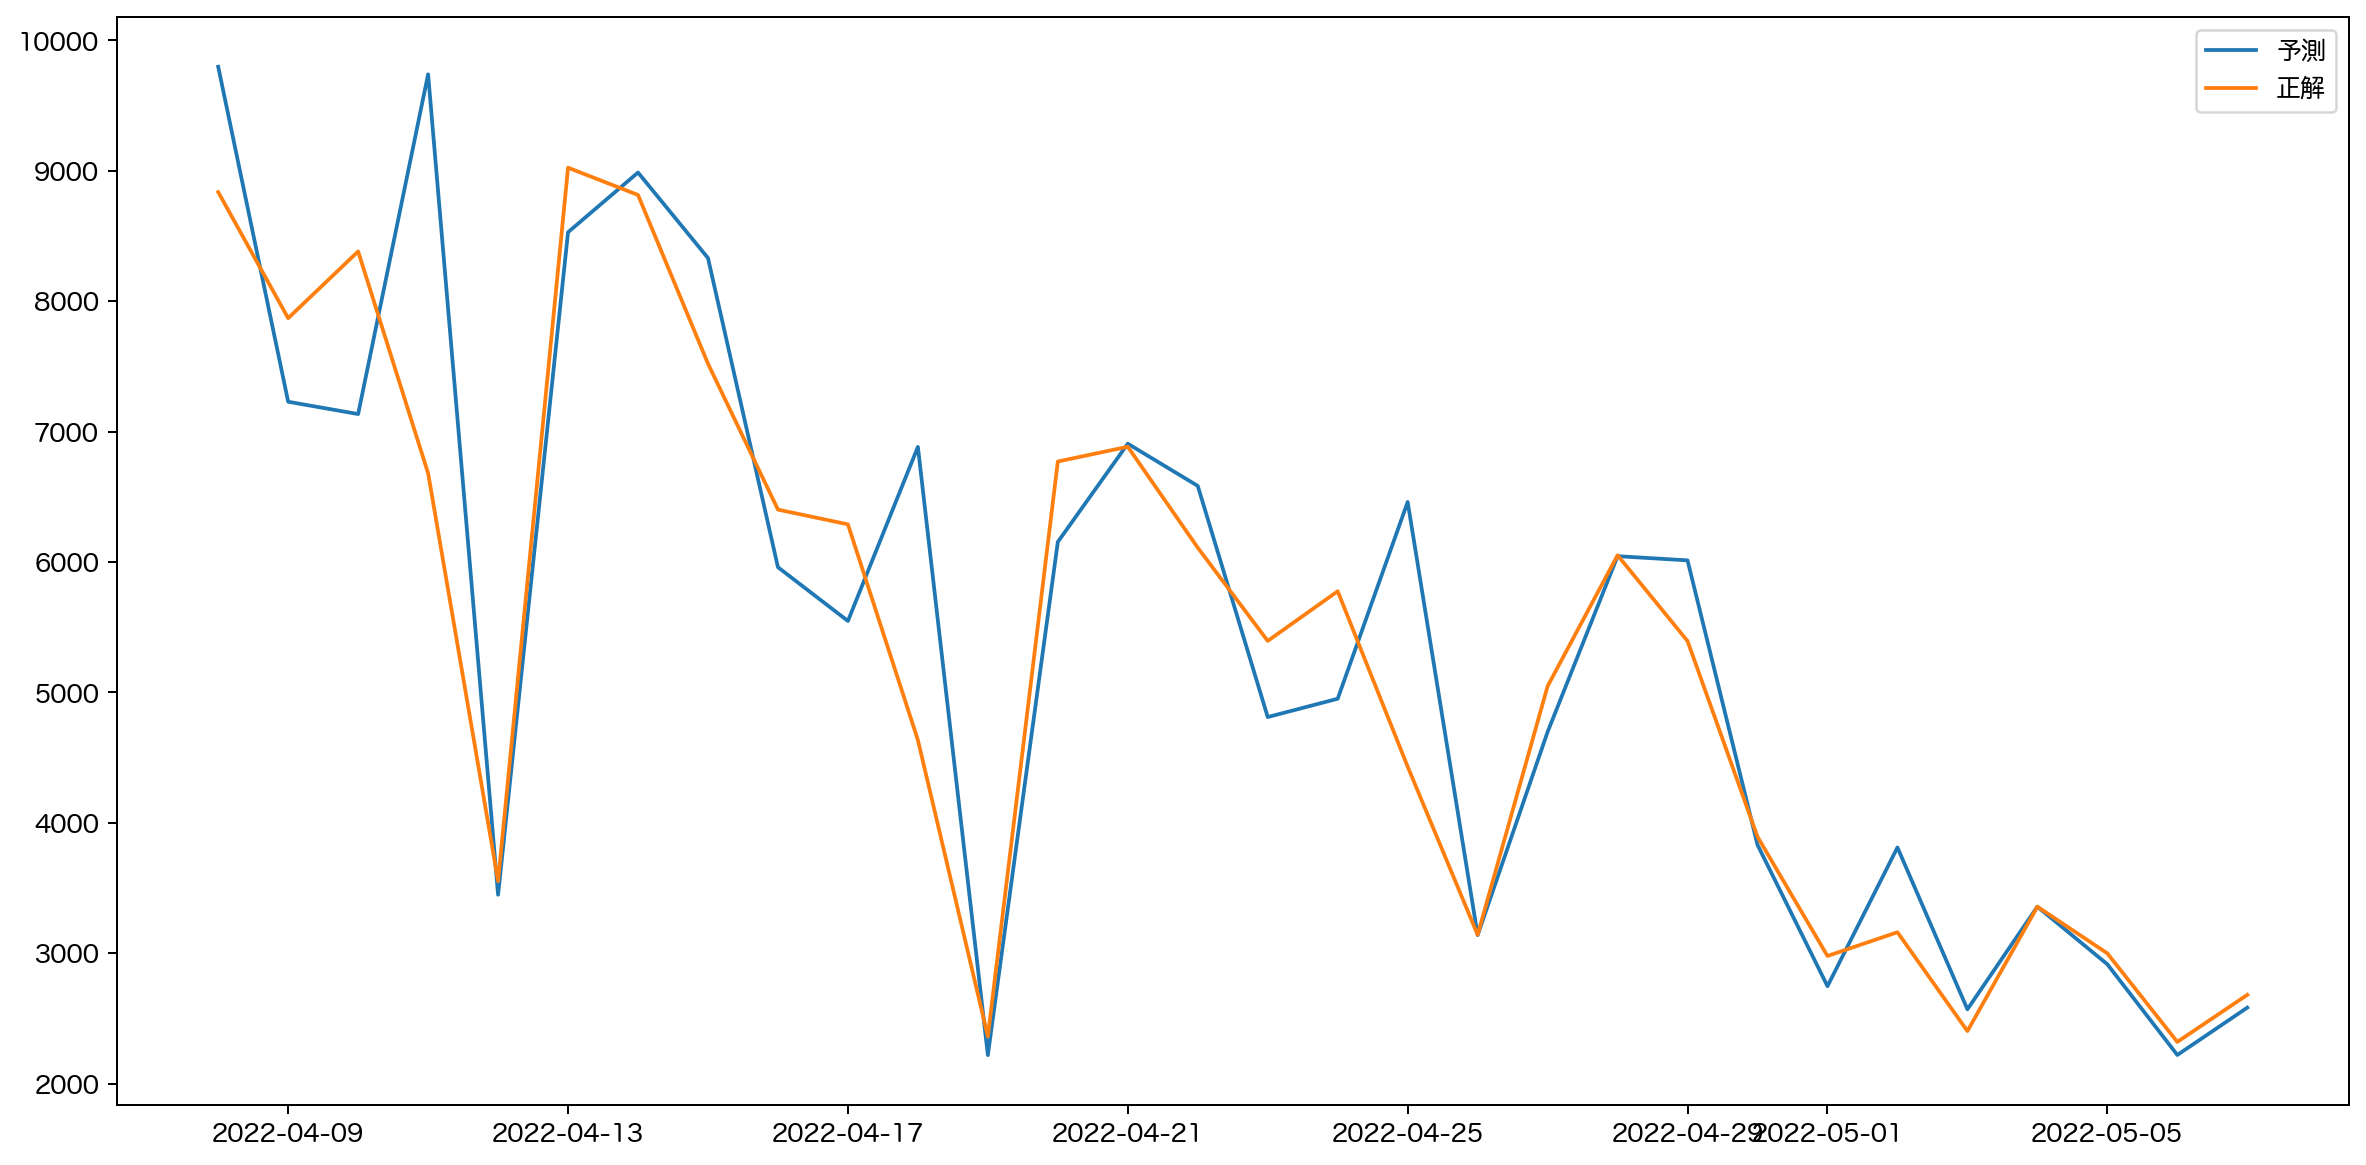

In [17]:
# テスト
fig = plt.figure(figsize=(16, 8), dpi=180)
ax = fig.add_subplot(111)
x = df.index[train_end+(N+w-1):test_end]
ax.plot(x, Yts_pred_inv_log_inv, label="予測")
ax.plot(x, Yts_org, label="正解")
ax.legend()
plt.show()

In [ ]:
# 明日の予測
Xts_new = 

In [18]:
Xts_trs.shape

(30, 8)